In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
##Import any other packages you may need here
import cv2
import pydicom
import scipy.stats

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.dropna(axis=1, how='all')

all_xray_df.dropna(axis=1, inplace=True)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*/images', '', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['Image Path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
92882,00023176_010.png,Atelectasis|Emphysema,10,23176,79,M,AP,3056,2544,0.139,0.139,/data/images_010/images/00023176_010.png
16011,00004261_000.png,No Finding,0,4261,49,F,PA,2048,2500,0.171,0.171,/data/images_003/images/00004261_000.png
90979,00022677_000.png,Atelectasis,0,22677,34,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00022677_000.png


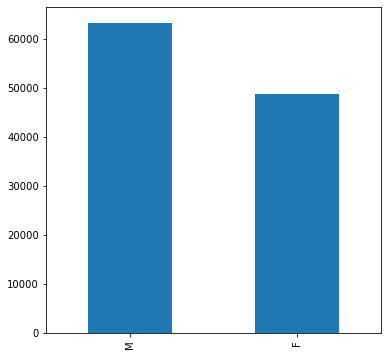

In [3]:
## EDA
# Demographic data for Patient Gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar') 

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

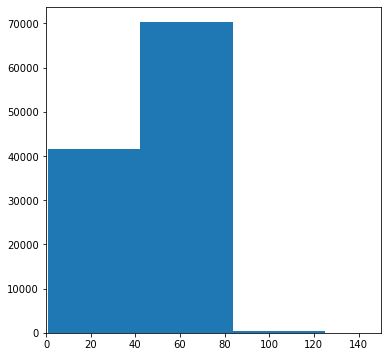

In [4]:
# Demographic data for Patient Age
plt.figure(figsize=(6,6))
plt.xlim(0, 150)
plt.hist(all_xray_df['Patient Age'])

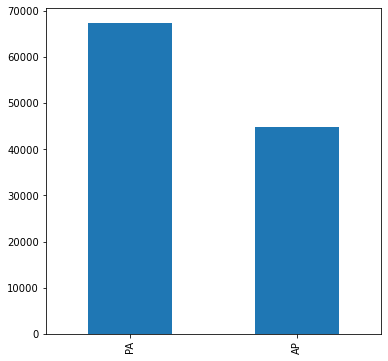

In [5]:
# Demographic data for Patient Position
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

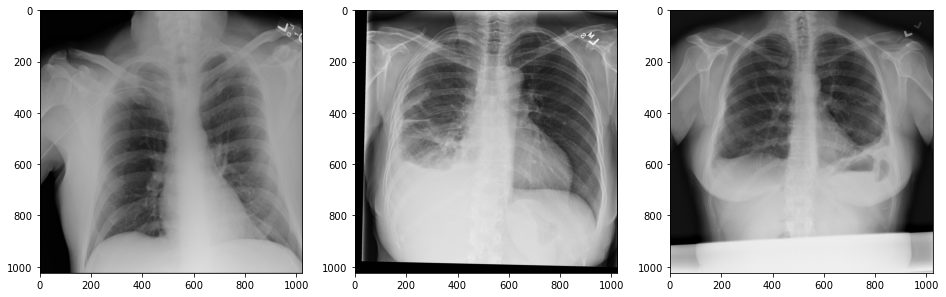

In [6]:
#Sample X ray Images from the dataset
j = 1
plt.figure(figsize=(16,16))
for i in all_xray_df.sample(3)["Image Path"]:
    plt.subplot(1,3,j)
    j=j+1
    plt.imshow(cv2.imread(i))

In [7]:
#Pneumonia Count
pneumonia_count = len(all_xray_df[all_xray_df['Finding Labels'].str.contains("Pneumonia")])
non_pneumonia_count = len(all_xray_df['Finding Labels'])- pneumonia_count
print("The total number of Pnemounia Cases in the dataset are:- " + str(pneumonia_count))
print("The total number of Non Pnemounia Cases in the dataset are:- " + str(non_pneumonia_count))

The total number of Pnemounia Cases in the dataset are:- 1431
The total number of Non Pnemounia Cases in the dataset are:- 110689


In [8]:
# Finding Unique Label Names
from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
69931,00017236_013.png,Infiltration,13,17236,46,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
83475,00020482_061.png,Edema|Infiltration|Pneumonia,61,20482,29,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
94014,00023815_000.png,No Finding,0,23815,34,F,PA,2836,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

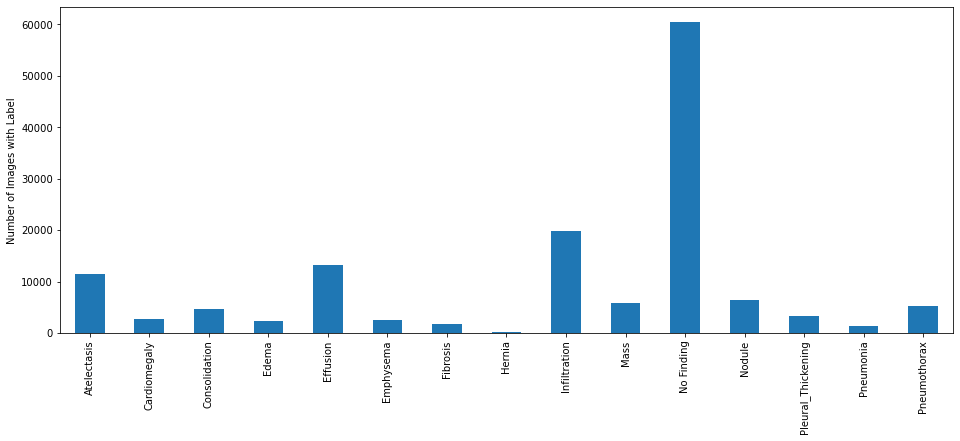

In [10]:
plt.figure(figsize=(16,6))
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

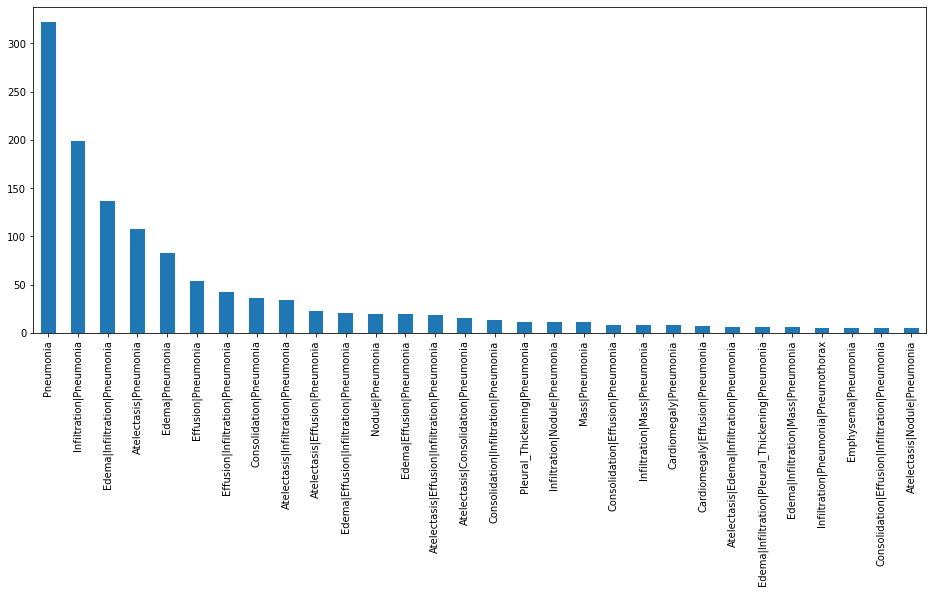

In [11]:
##Since there are many combinations of potential findings, We will be looking at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [12]:
#Number of disease per patient
count_list = [(all_xray_df.iloc[i][all_labels].sum()) for i in range(0, len(all_xray_df))]
    
idx = pd.Index(count_list, name ='disease_count').astype('int64')  
idx.value_counts()      

1    91324
2    14306
3     4856
4     1247
5      301
6       67
7       16
9        2
8        1
dtype: int64

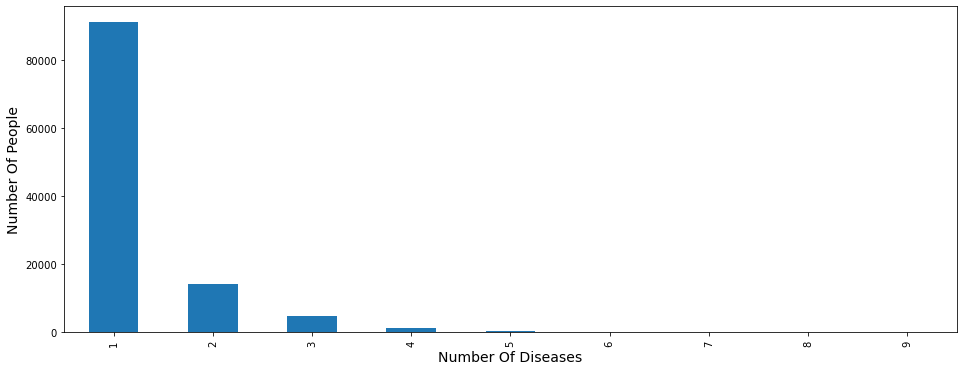

In [13]:
plt.figure(figsize=(16,6))
plt.xlabel('Number Of Diseases', fontsize=14)
plt.ylabel('Number Of People', fontsize=14)
idx.sort_values().value_counts().sort_index().plot(kind='bar')

In [14]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df['Image Path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image Path
478,00002505_001.png,No Finding,1,2505,028Y,M,PA,2992,2991,0.143,0.143,/data/images_002/images/00002505_001.png
3266,00016122_003.png,No Finding,3,16122,049Y,F,PA,2986,2991,0.143,0.143,/data/images_008/images/00016122_003.png
734,00003856_000.png,Pneumothorax,0,3856,062Y,F,AP,3056,2544,0.139,0.139,/data/images_002/images/00003856_000.png


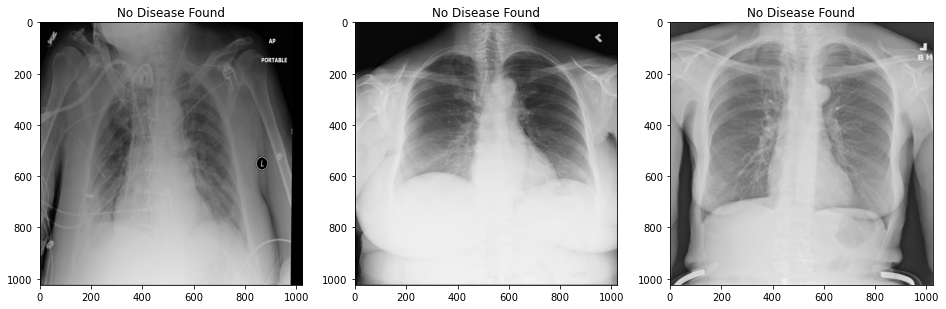

In [15]:
j = 1
img_list = []
plt.figure(figsize=(16,16))
for i in sample_df[sample_df["Finding Labels"] == "No Finding"].sample(3)["Image Path"]:
    img_list.append(i)
    plt.subplot(1,3,j)
    j=j+1
    plt.imshow(cv2.imread(i))
    plt.title("No Disease Found")

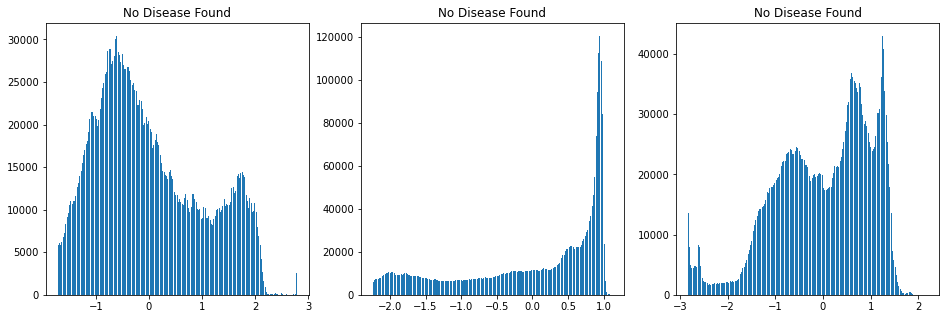

In [16]:
j = 1
plt.figure(figsize=(16,5))
for i in img_list:
    plt.subplot(1,3,j)
    j=j+1
    
    img = cv2.imread(i)
    img_mask = (img > 50)
    img = img[img_mask]

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity

    
    plt.hist(new_img.ravel(), bins=256)
    plt.title("No Disease Found")

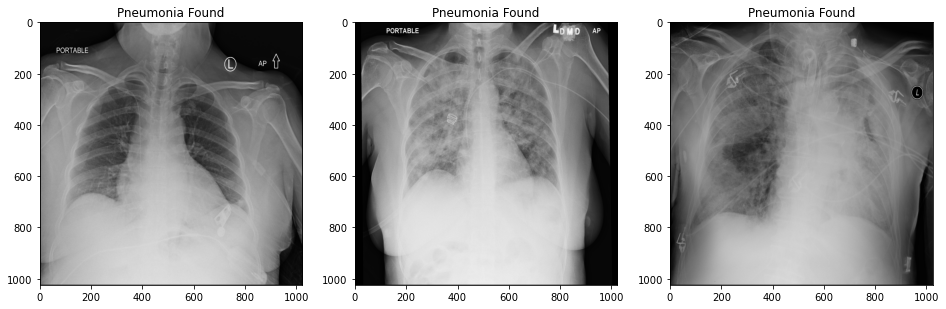

In [17]:
j = 1
img_list = []
plt.figure(figsize=(16,16))
for i in sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].sample(3)["Image Path"]:
    img_list.append(i)
    plt.subplot(1,3,j)
    j=j+1
    plt.imshow(cv2.imread(i))
    plt.title("Pneumonia Found")
    

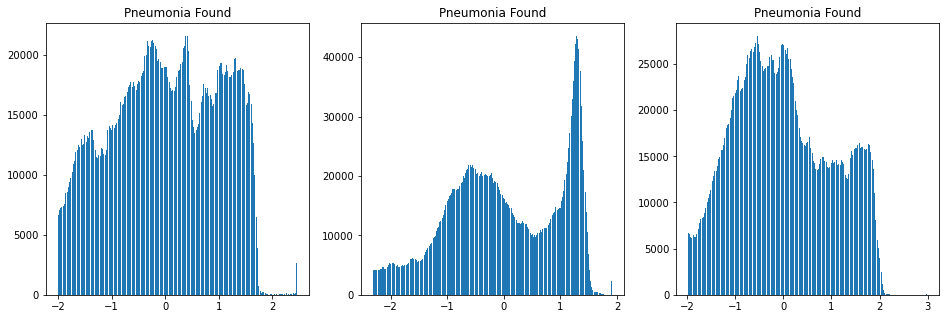

In [18]:
j = 1
plt.figure(figsize=(16,5))
for i in img_list:
    plt.subplot(1,3,j)
    j=j+1
    
    img = cv2.imread(i)
    img_mask = (img > 50)
    img = img[img_mask]
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    new_img = img.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    plt.hist(new_img.ravel(), bins=256)
    
    plt.title("Pneumonia Found")

In [30]:
thresh = 50
no_diseases = []

for i in sample_df[sample_df["Finding Labels"] == "No Finding"].sample(10)["Image Path"]:
    img = plt.imread(i) * 255
    img_mask = (img > thresh)
    no_diseases.extend(img[img_mask].tolist())    

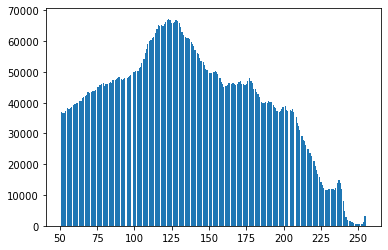

In [31]:
x = plt.hist(no_diseases,bins=256)

In [32]:
scipy.stats.mode(no_diseases)[0][0]

123.0

In [33]:
thresh = 50
pneumonia_diseases = []

for i in sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].sample(10)["Image Path"]:
    
    img = plt.imread(i) * 255
    img_mask = (img > thresh)
    pneumonia_diseases.extend(img[img_mask].tolist())

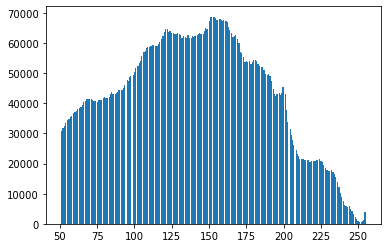

In [36]:
x = plt.hist(pneumonia_diseases,bins=256)

In [37]:
scipy.stats.mode(pneumonia_diseases)[0][0]

151.0